# Проект: классификация

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [53]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [54]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
#df.info()
df.isnull().sum()


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [55]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?

df['job'].value_counts()
#df['education'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [56]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan
df['balance'] = df['balance'].apply(make_convert)
round(df['balance'].mean(), 3)



1529.129

### Задание 4

In [57]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(), 3)


1526.936

### Задание 5

In [58]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].replace(['unknown'], 'management')
df['education'] = df['education'].replace(['unknown'], 'secondary')
#После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
#(т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). 
df.pivot_table(
    values ='balance',
    index = 'education',
    columns = 'job',
    aggfunc = 'mean',
    fill_value= 0
)
   

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
education,,,,,,,,,,,
primary,775.928571,1304.818444,1314.707317,1366.444444,1841.534247,2222.631769,1254.928571,1383.554217,1492.047619,1805.975610,1607.392857
secondary,1189.494662,1125.866889,1304.445161,1018.229885,1598.882979,2594.966759,1373.517007,1028.724269,1333.574219,1461.055511,1147.082949
tertiary,1343.482143,1730.062500,2090.189394,2069.162791,1826.104710,2314.992857,2254.047826,1279.754717,2018.722892,1766.792706,1552.666667


### Задание 6

In [59]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
  x = data[feature]
  quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
  iqr = quartile_3 - quartile_1
  lower_bound = quartile_1 - (iqr * 1.5)
  upper_bound = quartile_3 + (iqr * 1.5)
  outliers = data[(x<lower_bound)|(x>upper_bound)]
  cleaned = data[(x>lower_bound)|(x<upper_bound)]
  return outliers, cleaned 
outliers, cleaned = outliers_iqr(df, 'balance')

q_1 = df['balance'].quantile(0.25)
q_3 = df['balance'].quantile(0.75)
iqr = q_3 - q_1
lower_bound = q_1 - 1.5*iqr
upper_bound = q_3 + 1.5*iqr
df_cleaned = df[(df['balance'] >= lower_bound)&(df['balance'] <= upper_bound)].reset_index()


print(df_cleaned['balance'].describe())
print('25-й перцентиль: {},'.format(q_1),
      '75-й перцентиль: {},'.format(q_3),
      "IQR: {}, ".format(iqr),
      "Границы выбросов: [{lb}, {ub}].".format(lb=lower_bound, ub=upper_bound))

count    10105.000000
mean       807.653538
std        994.151966
min      -2049.000000
25%         95.000000
50%        445.000000
75%       1227.000000
max       4063.000000
Name: balance, dtype: float64
25-й перцентиль: 123.0, 75-й перцентиль: 1699.0, IQR: 1576.0,  Границы выбросов: [-2241.0, 4063.0].


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64


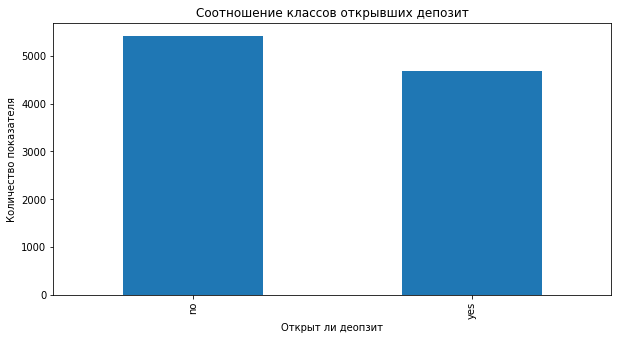

In [60]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
print(df_cleaned['deposit'].value_counts())
df_cleaned['deposit'].value_counts().plot(kind='bar', figsize=(10,5), xlabel= "Открыт ли деопзит", ylabel ="Количество показателя", grid=False, title="Соотношение классов открывших депозит")

### Задания 2 и 3

In [61]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df_cleaned['age'].max()

95

In [62]:
df_cleaned['duration'].min()

2

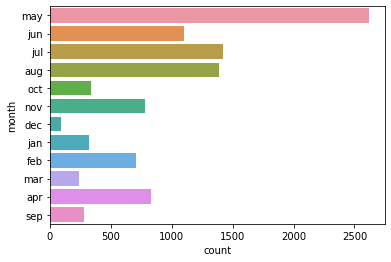

In [63]:
df_cleaned.describe(include = 'object')
sns.countplot(y='month', data=df_cleaned )

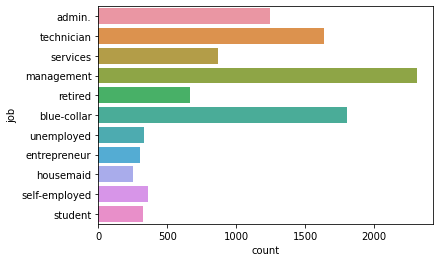

In [64]:
#Сколько сфер занятости представлено среди клиентов банка?
sns.countplot(y='job', data=df_cleaned )

In [65]:
#Напишите значение статуса предыдущей кампании, для которой в текущей успехов намного больше, чем неудач.
#display(df_cleaned.groupby('poutcome')['deposit'].value_counts())
df_cleaned['poutcome'].value_counts()

unknown    7570
failure    1109
success     945
other       481
Name: poutcome, dtype: int64

Рассчитайте, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить.

In [66]:
#Для каждого месяца необходимо рассчитать отношение отказов на общее количество принятых решений в этот месяц.
#Чтобы не прописывать одно и то же 12 раз, используйте цикл for
for i in np.unique(df_cleaned.month):
  print(i, df_cleaned[(df_cleaned.month == i) & (df_cleaned.deposit == 'no')].shape[0]/df_cleaned[df_cleaned.month == i].shape[0]*100)

apr 38.19277108433735
aug 55.95667870036101
dec 9.67741935483871
feb 45.55712270803949
jan 60.81504702194357
jul 58.956276445698165
jun 54.891304347826086
mar 10.126582278481013
may 67.86396637371035
nov 58.46153846153847
oct 18.507462686567163
sep 16.546762589928058


### Задания 4 и 5

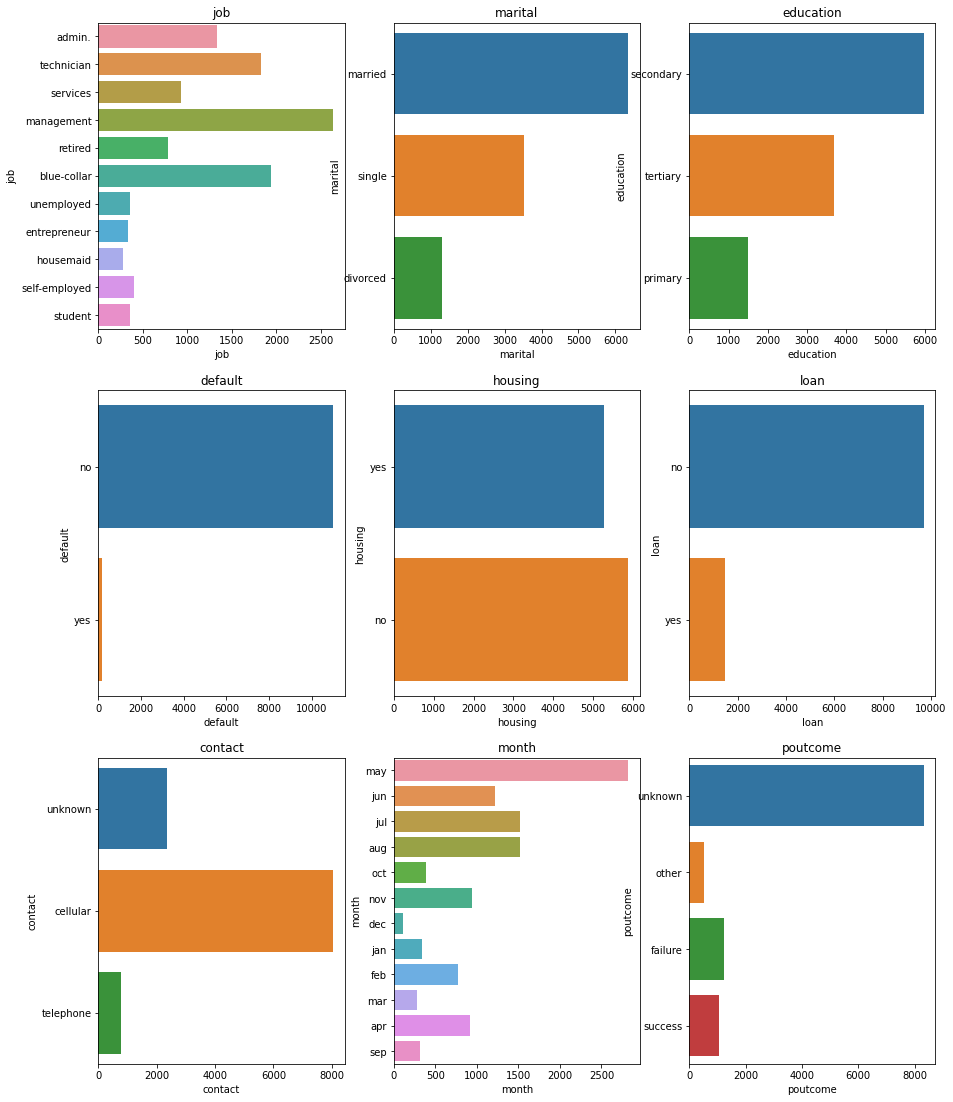

In [67]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df_cleaned.describe(include = 'object')
categorical_features=[feature for feature in df.columns if ((df_cleaned[feature].dtypes=='O') & (feature not in ['deposit']))]
import matplotlib.pyplot as plt
plt.figure(figsize=(15,80), facecolor='white')
plotnumber =1
for categorical_feature in categorical_features:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=categorical_feature,data=df)
    plt.xlabel(categorical_feature)
    plt.title(categorical_feature)
    plotnumber+=1
plt.show()

### Задание 6

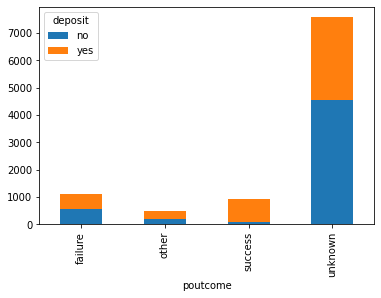

In [68]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
types = df_cleaned.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

In [69]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
res_n = df_cleaned[df_cleaned.deposit == 'no'].groupby(['month'])['deposit'].count()
res_k = df_cleaned.groupby(['month'])['deposit'].count()

res_n/res_k

month
apr    0.381928
aug    0.559567
dec    0.096774
feb    0.455571
jan    0.608150
jul    0.589563
jun    0.548913
mar    0.101266
may    0.678640
nov    0.584615
oct    0.185075
sep    0.165468
Name: deposit, dtype: float64

### Задание 8

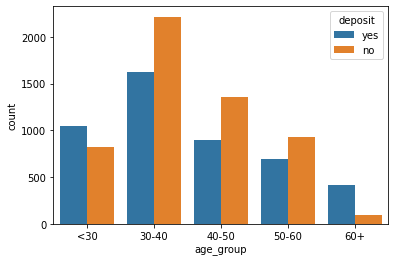

In [70]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

df_cleaned['age_group'] = pd.cut(df_cleaned.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df_cleaned)

### Задания 9 и 10

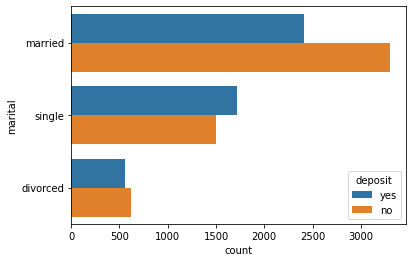

In [71]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=df_cleaned)

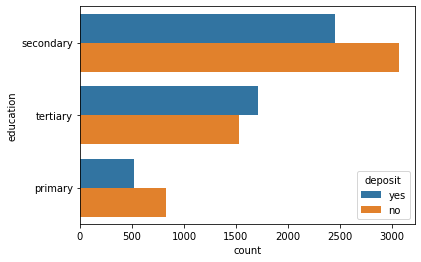

In [72]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=df_cleaned)

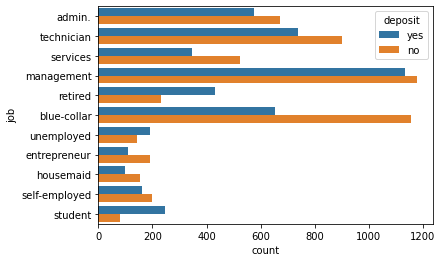

In [73]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=df_cleaned)

### Задание 11

In [79]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

bank1 = df_cleaned[df_cleaned.deposit == 'yes'][['education','marital','deposit']]
bank2 = df_cleaned[df_cleaned.deposit == 'no'][['education','marital','deposit']] 
res1 = pd.crosstab(bank1['education'],bank1['marital'])
res2 = pd.crosstab(bank2['education'],bank2['marital'])
print(res1)
print(res2)

marital    divorced  married  single
education                           
0                96      339      82
1               283     1289     879
2               174      784     755
marital    divorced  married  single
education                           
0                91      641     100
1               370     1830     866
2               163      832     531


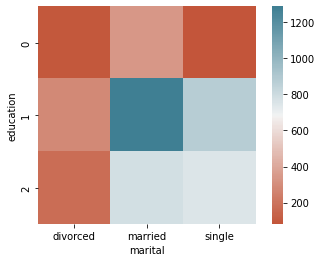

In [80]:
ax = sns.heatmap(
    res1, 
    #vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)

## Часть 3: преобразование данных

### Задание 1

In [81]:
# преобразуйте уровни образования

# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df_cleaned['education'] = lab_enc.fit_transform(df_cleaned['education'])
df_cleaned['education'].std()

0.6473728603595917

### Задания 2 и 3

In [44]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_cleaned["age_group"]

0        2
1        2
2        1
3        2
4        2
        ..
10100    0
10101    0
10102    0
10103    1
10104    0
Name: age_group, Length: 10105, dtype: int64

In [45]:
le = LabelEncoder()
df_cleaned["age_group"] = le.fit_transform(df_cleaned["age_group"])
df_cleaned["age_group"]

0        2
1        2
2        1
3        2
4        2
        ..
10100    0
10101    0
10102    0
10103    1
10104    0
Name: age_group, Length: 10105, dtype: int64

### Задание 4

In [46]:
# создайте дамми-переменные
def bin_func(row):
    if row == 'yes':
        return 1
    else:
        return 0

df_cleaned['deposit'] = df_cleaned['deposit'].apply(bin_func)


In [48]:
df_cleaned['deposit'].std()

0.0

In [49]:
df_cleaned['default'] = df_cleaned['default'].apply(bin_func)
df_cleaned['housing'] = df_cleaned['housing'].apply(bin_func)
df_cleaned['loan'] = df_cleaned['loan'].apply(bin_func)

df_cleaned.head(15)

,index,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,0,59,admin.,married,1,0,2343.0,0,0,unknown,5,may,1042,1,-1,0,unknown,0,2
1,1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,0,2
2,2,41,technician,married,1,0,1270.0,0,0,unknown,5,may,1389,1,-1,0,unknown,0,1
3,3,55,services,married,1,0,2476.0,0,0,unknown,5,may,579,1,-1,0,unknown,0,2
4,4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,0,2
5,5,42,management,single,2,0,0.0,0,0,unknown,5,may,562,2,-1,0,unknown,0,1
6,6,56,management,married,2,0,830.0,0,0,unknown,6,may,1201,1,-1,0,unknown,0,2
7,7,60,retired,divorced,1,0,545.0,0,0,unknown,6,may,1030,1,-1,0,unknown,0,2
8,8,37,technician,married,1,0,1.0,0,0,unknown,6,may,608,1,-1,0,unknown,0,0
9,9,28,services,single,1,0,550.0,0,0,unknown,6,may,1297,3,-1,0,unknown,0,4


### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [ ]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna